<a href="https://colab.research.google.com/github/carlosinator/cil-sentiment/blob/main/resource_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
from pathlib import Path

# Analyze GPU History

In [3]:
A100_p0 = 0.4 # see here for SXM: https://www.nvidia.com/en-us/data-center/a100/

In [36]:
# copy gpu history
EXPERIMENTS = {
    "BASEMODEL_v0": "gpu_hist_basemodel.pkl", # LR=2e-5, EPOCHS=10, stopped after 4th epoch, batch_size=256
    "READ_v0": "gpu_hist_read.pkl", # LR=2e-5, EPOCHS=10, batch_size=256, UNITS=8
    "READ_v1": "gpu_hist_inference_read_fullmodel_lr0.0002_ep10_batchs=256.pkl",
    "READ_v2": "gpu_hist_inference_read_fullmodel_lr0.0002_ep10_batchs=256_gru_units=32.pkl",
    "READ_v3": "gpu_hist_inference_read_fullmodel_lr0.0002_ep10_batchs=256_gru_units=64.pkl",
    "READ_v4": "gpu_hist_inference_read_fullmodel_lr0.0002_ep10_batchs=64_gru_units=32.pkl",
    "READ_v5": "gpu_hist_inference_read_fullmodel_lr0.001_ep10_batchs=256_gru_units=32.pkl",
    "READ_v6": "gpu_hist_inference_read_fullmodel_lr0.001_ep10_batchs=64_gru_units=64.pkl",
    "READ_v7": "gpu_hist_inference_read_fullmodel_lr2e-05_ep10_batchs=256_gru_units=64.pkl",
    "READ_v8": "gpu_hist_inference_read_fullmodel_lr2e-06_ep10_batchs=256_gru_units=32.pkl",
    "READVAR_v0": "gpu_hist_inference_read-var_fullmodel_lr0.001_ep10_batchs=128_gru_units=128.pkl",
    "READVAR_v1": "gpu_hist_inference_read-var_fullmodel_lr0.001_ep10_batchs=256_gru_units=16.pkl",
    "READVAR_v2": "gpu_hist_inference_read-var_fullmodel_lr0.001_ep10_batchs=256_gru_units=256.pkl",
    "READVAR_v3": "gpu_hist_inference_read-var_fullmodel_lr0.001_ep10_batchs=256_gru_units=32.pkl",
    "READVAR_v4": "gpu_hist_inference_read-var_fullmodel_lr0.001_ep10_batchs=256_gru_units=64.pkl",
    "READVAR_v5": "gpu_hist_inference_read-var_fullmodel_lr0.001_ep10_batchs=256_gru_units=8.pkl",
}


In [5]:
CURRENT_EXP = EXPERIMENTS["BASEMODEL_v0"]

In [9]:
# helper function
def remove_trailing_zeros(array):
    last_index = len(array) - 1

    # Find the last non-zero element
    while last_index >= 0 and array[last_index] == 0:
        last_index -= 1

    # Resize the array to exclude trailing zeros
    array = array[0:last_index + 1]

    return array

In [23]:
def load_experiment(exp_name: str):
  if not Path(exp_name).exists():
    fname = "gs://cil_2023/models/" + exp_name
    !gsutil cp $fname .

  with open(exp_name, 'rb') as file:
    # Load the pickled object
    unpickled_object = pickle.load(file)

    # remove trailing zeros (due to some bugs, this may occur, if gpu measurement does not automatically stop)
    unpickled_object["percent"] = remove_trailing_zeros(unpickled_object["percent"])
    return unpickled_object

def experiment_duration(percent_values, interval):
    total_time_seconds = len(percent_values) * interval

    # Convert total_time_seconds to hours and minutes
    total_time_minutes, seconds = divmod(total_time_seconds, 60)
    hours, minutes = divmod(total_time_minutes, 60)

    print(f"Total time measured: {total_time_seconds} seconds")
    print(f"Total time measured: {hours} hours and {minutes} minutes")
    print(f"Total time measured: {total_time_minutes} minutes and {seconds} seconds")


    return total_time_seconds, hours, minutes

In [17]:
def compute_energy_consumption(utilization_percents: list, interval: int, p0: float = 1):
    # Calculate the number of entries per minute
    entries_per_minute = (int)(60 // interval)

    # Check if the utilization_percents length is a multiple of entries_per_minute
    # If not, it means the last minute is incomplete, and we should only consider complete minutes for the calculation
    if len(utilization_percents) % entries_per_minute != 0:
        drop_count = (int)(len(utilization_percents) % entries_per_minute)
        utilization_percents = utilization_percents[:-drop_count]

    # Reshape the utilization_percents to a 2D array with 'entries_per_minute' columns
    utilization_percents = np.array(utilization_percents).reshape(-1, entries_per_minute)

    # Create utilization_percents_per_minutes list by taking the average of each row
    utilization_percents_per_minutes = utilization_percents.mean(axis=1)


    # Compute the total energy consumption
    total_energy_consumption = np.sum(utilization_percents_per_minutes) * p0 / 6000

    # result is in kWH
    return total_energy_consumption

In [18]:
def plot_percent_values(datapoints,
                        interval,
                        y_axis_title='GPU Ressource utilization',
                        y_label='GPU Ressource utilization [%]',
                        plot_title='GPU Ressource utilization over Time'):
    # Create a range of time values in minutes
    time_values = np.arange(0, len(datapoints)*interval, interval) / 60

    # Create a DataFrame to hold time and percent values
    df = pd.DataFrame({
        'time [in min]': time_values,
        'GPU Ressource utilization': datapoints
    })

    # Create the plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='time [in min]', y=y_axis_title)

    # Set titles
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel('time [in min]')

    # Display the plot
    plt.show()

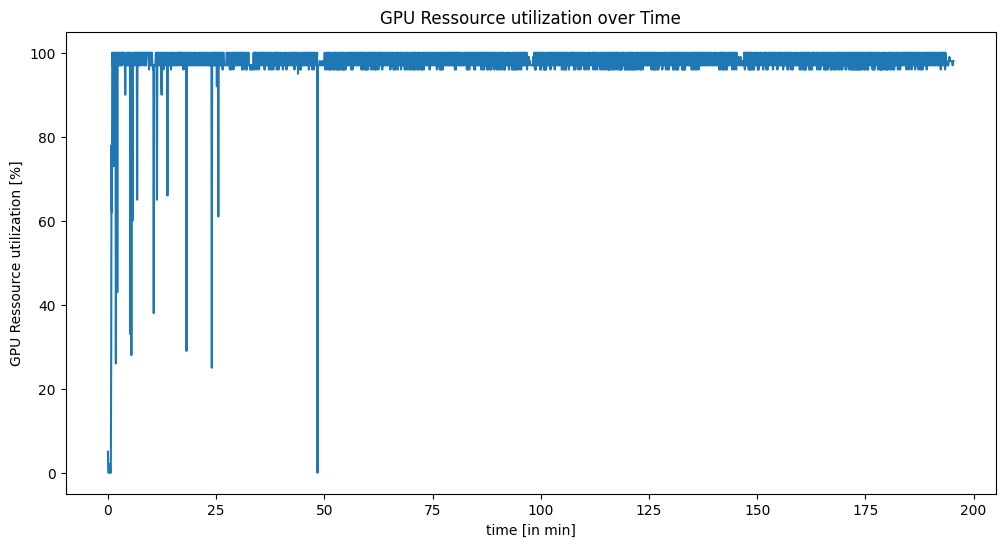

Total time measured: 11725.0 seconds
Total time measured: 3.0 hours and 15.0 minutes
Total time measured: 195.0 minutes and 25.0 seconds


(11725.0, 3.0, 15.0)

In [24]:
gpu_hist = load_experiment(EXPERIMENTS["BASEMODEL_v0"])
plot_percent_values(datapoints=gpu_hist['percent'], interval=gpu_hist["interval"])
experiment_duration(percent_values=gpu_hist["percent"], interval=gpu_hist["interval"])

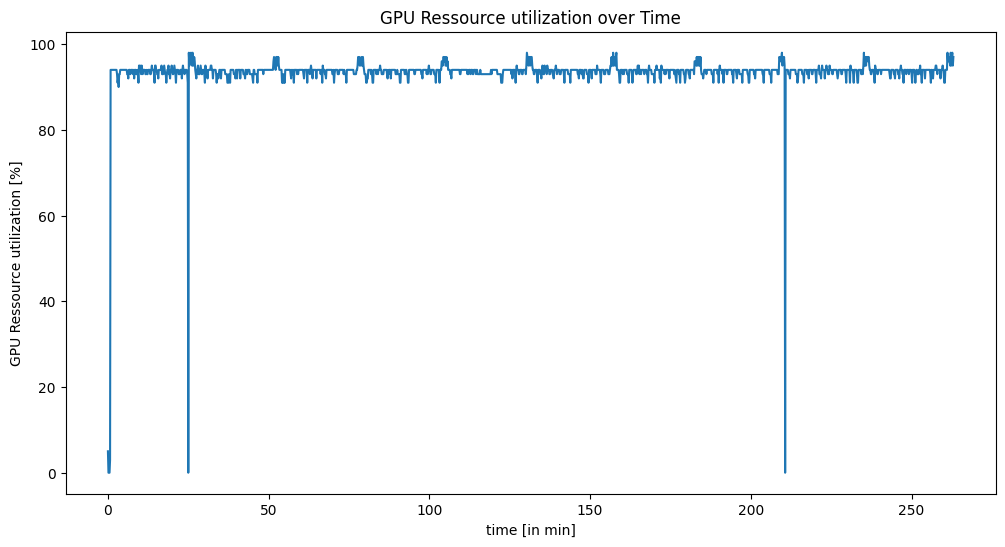

Total time measured: 15790.0 seconds
Total time measured: 4.0 hours and 23.0 minutes
Total time measured: 263.0 minutes and 10.0 seconds


(15790.0, 4.0, 23.0)

In [25]:
gpu_hist = load_experiment(EXPERIMENTS["READ_v0"])
plot_percent_values(datapoints=gpu_hist['percent'], interval=gpu_hist["interval"])
experiment_duration(percent_values=gpu_hist["percent"], interval=gpu_hist["interval"])

In [ ]:
gpu_hist = load_experiment(EXPERIMENTS["BASEMODEL_v0"])
compute_energy_consumption(gpu_hist["percent"], interval=gpu_hist["interval"], p0=A100_p0)

1.2678333333333334

In [ ]:
gpu_hist = load_experiment(EXPERIMENTS["READ_v0"])
compute_energy_consumption(gpu_hist["percent"], interval=gpu_hist["interval"], p0=A100_p0)

1.6375888888888888

## Plot experiment duration


In [44]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_experiment_durations(experiment_names):
    # Create a list to store the experiment data
    experiment_data = []

    # Iterate over all the paths and load the experiment data
    for en in experiment_names:
        experiment = load_experiment(en)
        total_time_seconds, _, _ = experiment_duration(
            percent_values=experiment["percent"],
            interval=experiment["interval"]
        )

        # Apply the transformation to the label
        extracted_label = en
        if extracted_label.count('_') >= 5:
            extracted_label = extracted_label.split('_', 5)[-1]
        extracted_label = extracted_label[:-4]

        experiment_data.append({"Name": extracted_label, "Duration": total_time_seconds})

    # Convert the list to a DataFrame
    df = pd.DataFrame(experiment_data)

    # Ensure the 'Duration' column is numeric
    df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')

    print(df)

    # Create the seaborn plot
    plt.figure(figsize=(10,6))
    plot = sns.barplot(y="Name", x="Duration", data=df, orient="h")

    # Add labels for each bar
    #for i in range(df.shape[0]):
    #    plot.text(df.Duration[i], i, df.Name[i], color='black', ha="right")

    # Show the plot
    plt.xlabel('Duration')
    plt.ylabel('Experiment')
    plt.title('Experiment Durations')
    plt.show()


Total time measured: 11725.0 seconds
Total time measured: 3.0 hours and 15.0 minutes
Total time measured: 195.0 minutes and 25.0 seconds
Total time measured: 15790.0 seconds
Total time measured: 4.0 hours and 23.0 minutes
Total time measured: 263.0 minutes and 10.0 seconds
Total time measured: 15920.0 seconds
Total time measured: 4.0 hours and 25.0 minutes
Total time measured: 265.0 minutes and 20.0 seconds
Total time measured: 16400.0 seconds
Total time measured: 4.0 hours and 33.0 minutes
Total time measured: 273.0 minutes and 20.0 seconds
Total time measured: 17500.0 seconds
Total time measured: 4.0 hours and 51.0 minutes
Total time measured: 291.0 minutes and 40.0 seconds
Total time measured: 29660.0 seconds
Total time measured: 8.0 hours and 14.0 minutes
Total time measured: 494.0 minutes and 20.0 seconds
Total time measured: 16330.0 seconds
Total time measured: 4.0 hours and 32.0 minutes
Total time measured: 272.0 minutes and 10.0 seconds
Total time measured: 32010.0 seconds
Tota

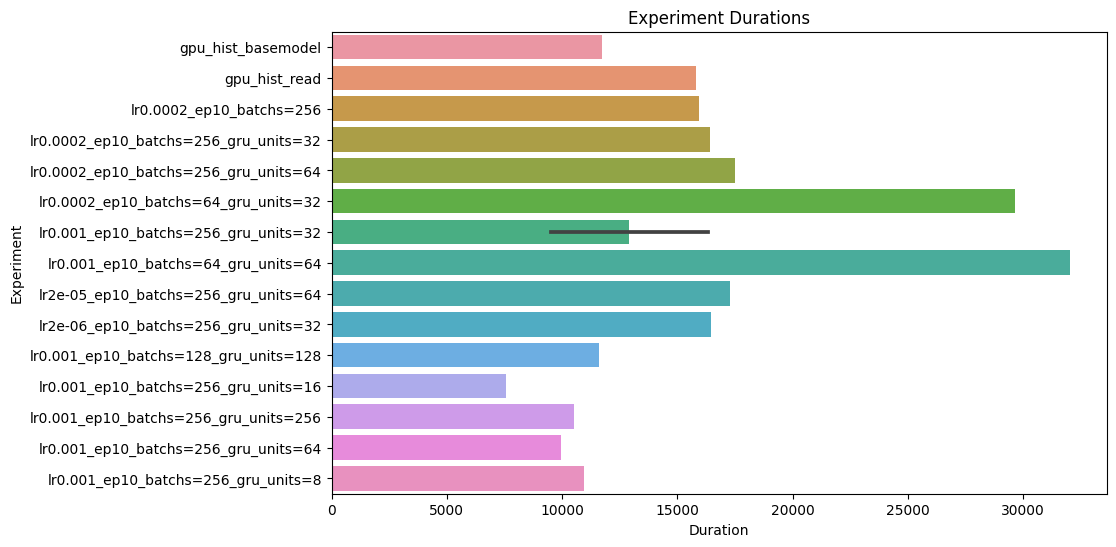

In [45]:
plot_experiment_durations(EXPERIMENTS.values())